In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import h5py
import json
import os
import copy
from IPython.display import display, HTML

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
libpath = os.path.join(path1p, "lib")

sys.path.insert(0, libpath) 
print("Appended library directory", libpath)

# Local libraries
from qt_wrapper import gui_fname, gui_fnames, gui_fpath
from matlab_lib import loadmat

%load_ext autoreload
%autoreload 2

Appended library directory /media/aleksejs/DataHDD/work/codes/comp-neuro/analysis-tracking/dlc-scripts/scripts/lib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load DLC-Tracked Data

In [124]:
# DLC Tracked DATA
param = {}
param["H5_FNAMES"] = gui_fnames("Open DLC session results files for same mouse", "./", "HDF5 files (*.h5)")

In [170]:
pValues = {}
mouseDLCFrame = []
for fname in param["H5_FNAMES"]:
    dlc_h5_file = h5py.File(fname, "r")
    
    key = os.path.basename(fname)[:-3]
    nodeNames = np.array(dlc_h5_file['NODE_NAMES'])
    dictThisDay = {
        'nTimesMax' : dlc_h5_file['X'].shape[0],
        'nNodes'    : dlc_h5_file['X'].shape[1],
        'nTrials'   : dlc_h5_file['X'].shape[2],
        'fps'       : float(np.array(dlc_h5_file['FPS'])),
        'vidpath'   : np.string_(dlc_h5_file.attrs['VID_PATH']).decode(),
    }
    
    mouseDLCFrame += [pd.DataFrame(dictThisDay, index=(key,))]
    pValues[key] = np.array(dlc_h5_file['P'])
    
mouseDLCFrame = pd.concat(mouseDLCFrame)
display(mouseDLCFrame)

,fps,nNodes,nTimesMax,nTrials,vidpath
mtp_13_2017_03_09_a,200.0,9,1949,940,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_10_a,200.0,9,1965,760,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_13_a,200.0,9,1944,248,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_14_a,200.0,9,1959,825,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_15_a,200.0,9,1944,555,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_16_a,200.0,9,1950,694,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_17_a,200.0,9,1944,868,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_20_a,200.0,9,1962,230,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_21_a,200.0,9,1960,656,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...
mtp_13_2017_03_22_a,200.0,9,1953,590,/media/hpc_user/MyBook10/whisk_data/mtp_13/mtp...


In [13]:
# Human Tracked DATA
matHumanTrackedFname  = gui_fname("Open matlab file", "./", "Matlab Files (*.mat)")
matHumanTracked = loadmat(matHumanTrackedFname)

In [177]:
# Sanity Checks
def getTouchFromId(mat, targetId):
    for iMouse, mouseDays in enumerate(mat['sessions_IDs']):
        for iDay, thisId in enumerate(mouseDays):
            if thisId == targetId:
                return mat['whisk_touch'][iMouse][iDay]
    return None
    

for key, row in mouseDLCFrame.iterrows():
    delThis = True
    nTrialsDLC = row['nTrials']

    touchTimesHuman = getTouchFromId(matHumanTracked, key)
    if touchTimesHuman is None:
        print(key, "is not in pool")
    elif touchTimesHuman.shape[0] == 0:
        print(key, "was not human-tracked")
    else:
        nTrialHuman = touchTimesHuman.shape[0]
        assert nTrialHuman == nTrialsDLC, "Number of trials for human vs DLC does not match"
        print(key, "is consistent for nTrials =", nTrialsDLC)
        delThis = False
    
    if delThis:
        mouseDLCFrame.drop(key, inplace=True)

mtp_13_2017_03_09_a is consistent for nTrials = 940
mtp_13_2017_03_13_a is consistent for nTrials = 248
mtp_13_2017_03_14_a is consistent for nTrials = 825
mtp_13_2017_03_15_a is consistent for nTrials = 555
mtp_13_2017_03_16_a is consistent for nTrials = 694
mtp_13_2017_03_17_a is consistent for nTrials = 868
mtp_13_2017_03_20_a is consistent for nTrials = 230
mtp_13_2017_03_21_a is consistent for nTrials = 656
mtp_13_2017_03_22_a is consistent for nTrials = 590


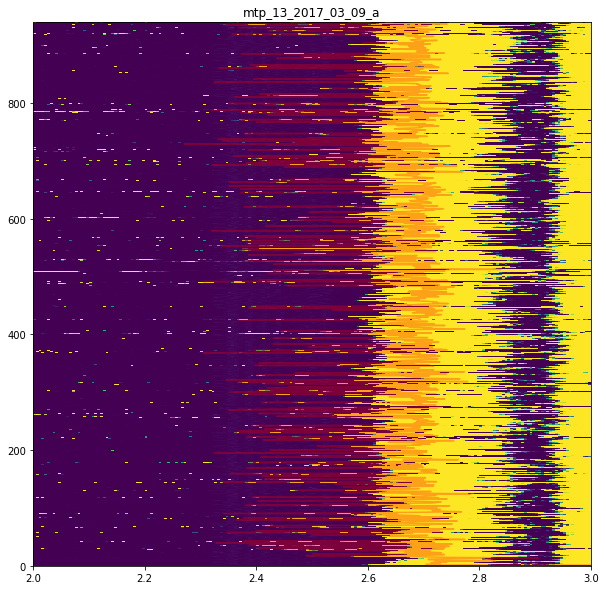

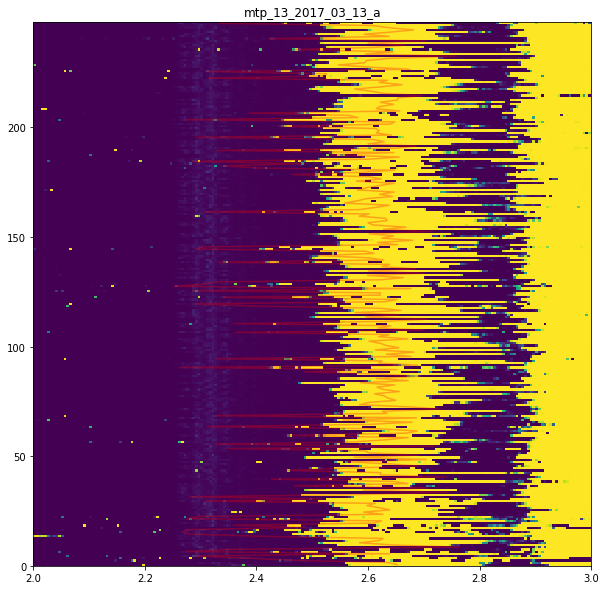

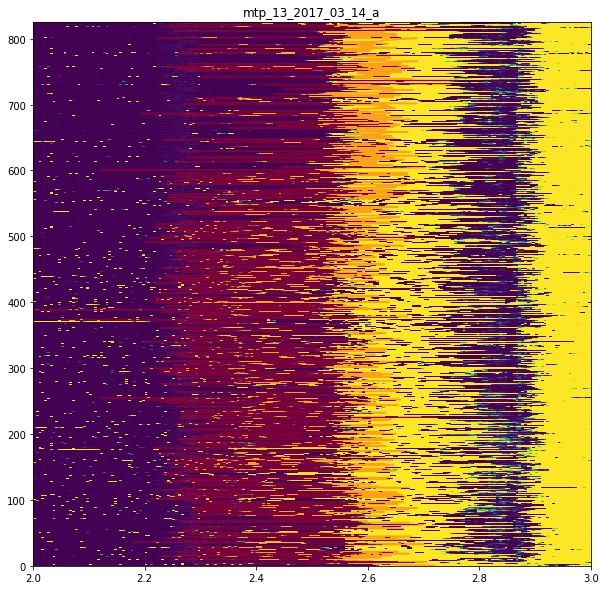

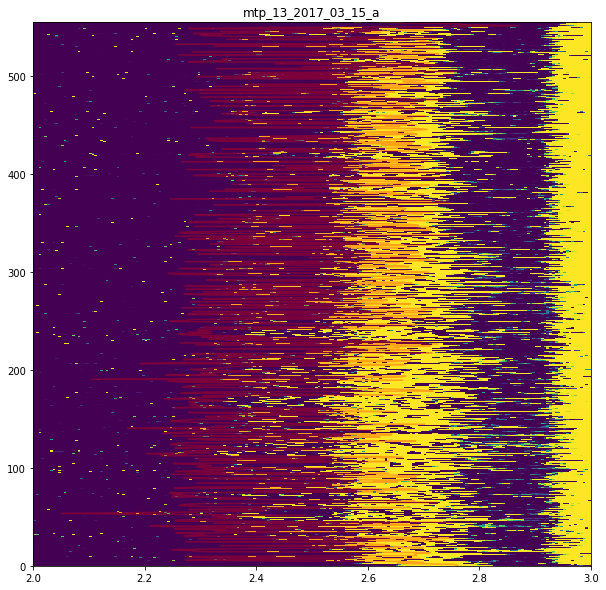

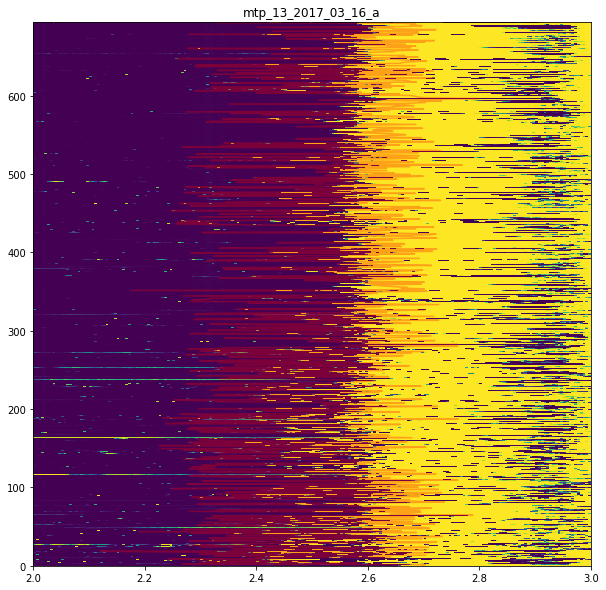

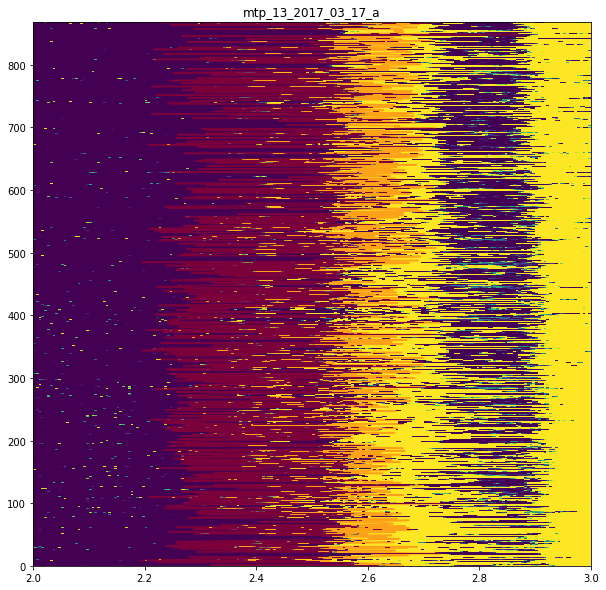

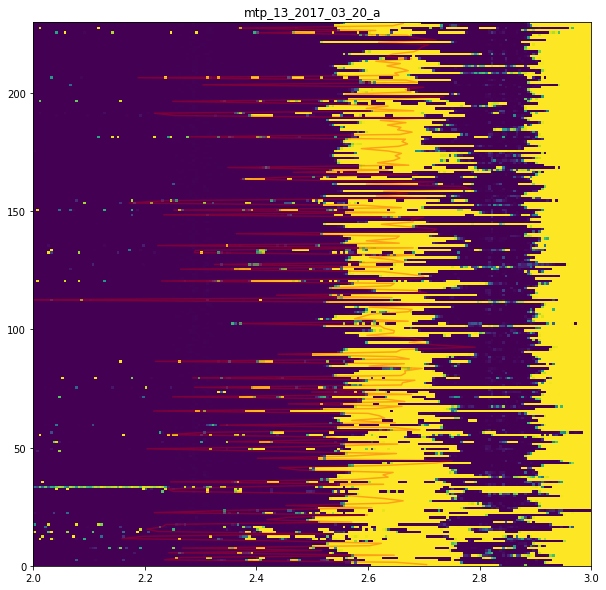

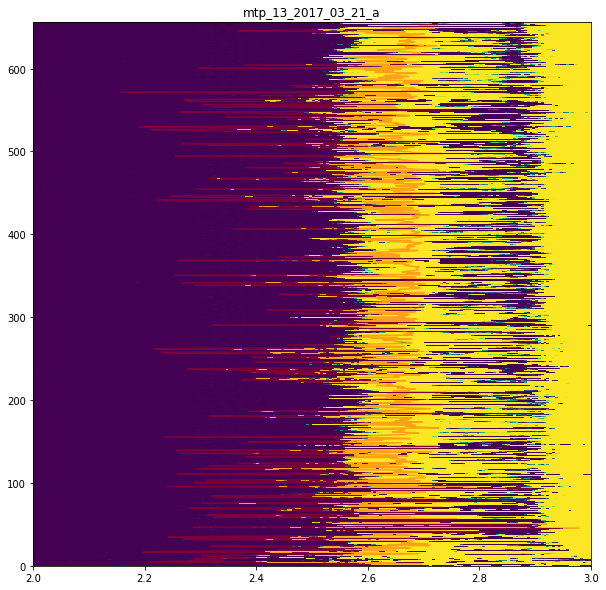

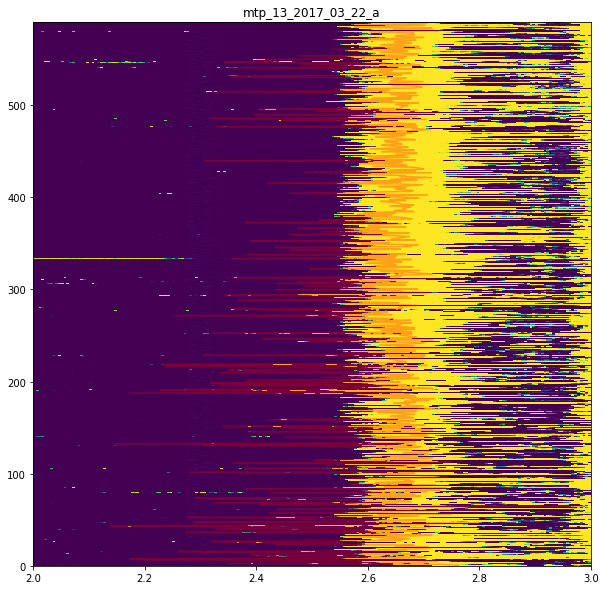

In [229]:
pThr = 0.01
idxTouch = np.where(nodeNames=="Touch")[0][0]

for key, row in mouseDLCFrame.iterrows():
    # DLC predicted touch times
    pValThis = pValues[key][:, IDX_TOUCH, :].T
    # pErrThis = 1 - pValThis
    #pErrThis[np.isnan(pErrThis)] = 1
    #haveTouch = pErrThis < pThr

    # Human predicted first touch times
    touchTimesHuman = getTouchFromId(matHumanTracked, key)
    
    #print(pValThis.shape, touchTimesHuman.shape)

    plt.figure(figsize=(10, 10))
    plt.title(key)
    plt.imshow(pValThis, origin='lower', aspect='auto', extent=[0, row['nTimesMax'] / row['fps'], 0, row['nTrials']])
    plt.plot(touchTimesHuman, np.arange(row['nTrials'])+0.5, color='r', alpha=0.3)
    plt.xlim(2,3)
    plt.show()

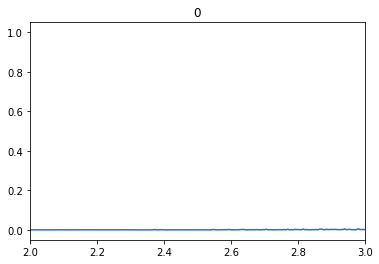

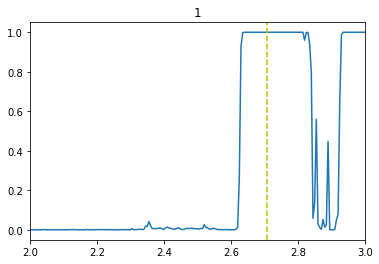

In [233]:
for trialThis in range(2):
    #trialThis = 835 #mouseDLCFrame.loc[keyThis]['nTrials']-1
    keyThis = mouseDLCFrame.index[0]
    touchTimesHumanThis = getTouchFromId(matHumanTracked, keyThis)[trialThis]


    pValThis = pValues[keyThis][:, IDX_TOUCH, trialThis]
    nTimesThis = len(pValThis)
    tValThis = np.arange(nTimesThis) / mouseDLCFrame.loc[keyThis]['fps']

    plt.figure()
    plt.title(trialThis)
    plt.plot(tValThis, pValThis)
    plt.axvline(x = touchTimesHumanThis, linestyle='--', color='y')
    plt.xlim(2,3)
    plt.show()

# 2. Load Human-Tracked Data

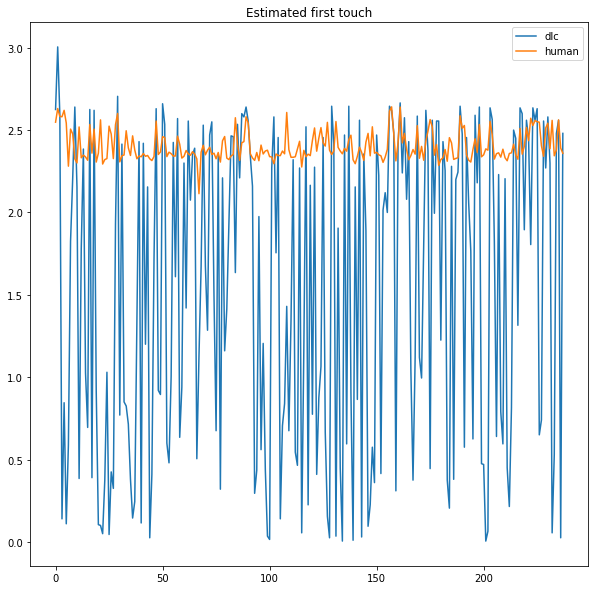

In [35]:
def frame2time(frame, fps):
    return (frame + 1) / fps


    
# Get indices for mouse and day
mouseDayId = os.path.basename(param["H5_FNAME"])[:-3]
mouseIdx, dayIdx = getMouseDayIdxs(matHumanTracked['sessions_IDs'], mouseDayId)

# Get associated human-tracked times
touchTimesHuman = matHumanTracked['whisk_touch'][mouseIdx][dayIdx]

# Estimate first touch from DLC data
touchTimesDLC = np.full(N_TRIALS, np.nan)
for iTrial in range(N_TRIALS):
    candidates = np.where(HAVE_TOUCH[iTrial])[0]
    if len(candidates) > 0:
        touchTimesDLC[iTrial] = frame2time(np.min(candidates), FPS)
    
# Convert first touch from bin number to time
plt.figure(figsize=(10,10))
plt.title("Estimated first touch")
plt.plot(touchTimesDLC, label='dlc')
plt.plot(touchTimesHuman, label='human')
plt.legend()
plt.show()

In [63]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

ValueError: Unknown label type: 'continuous'

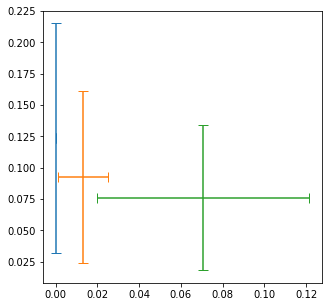

In [108]:
def time2frame(t, fps):
    return int(t * fps)-1

def errMuStd(y, ytrue):
    err = np.abs(y-ytrue)
    return np.mean(err), np.std(err)

tDataStart = 2.0 # seconds
tDataEnd = 3.5   # seconds
idxDataStart = time2frame(tDataStart, FPS)
idxDataEnd = time2frame(tDataEnd, FPS)

data = HAVE_TOUCH[:, idxDataStart:idxDataEnd]
labels = touchTimesHuman

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2)

methodDict = {
    "Linear Regression" : linear_model.LinearRegression(),
    "Ridge Regression"  : linear_model.Ridge(alpha=.9),    # L2 reg
    "Lasso"             : linear_model.Lasso(alpha=0.5),   # L1 reg
    #"Elastic"           : linear_model.ElasticNet(alpha=0.3, l1_ratio=0.5),  #L2 and L1 reg
    #"BayesianRidge"     : linear_model.BayesianRidge(),
    "Logistic Regression" : linear_model.LogisticRegression(penalty='l1', solver='saga',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True)
}

plt.figure(figsize=(5,5))

for modelName, modelClass in methodDict.items():
    modelClass.fit(X_train, y_train)
    y_train_predict = modelClass.predict(X_train)
    y_test_predict = modelClass.predict(X_test)
    
    errTrainMu, errTrainStd = errMuStd(y_train_predict, y_train)
    errTestMu, errTestStd = errMuStd(y_test_predict, y_test)
    
    plt.errorbar(errTrainMu, errTestMu, capsize=5, yerr=errTestStd, xerr=errTrainStd, label=modelName)

plt.xlabel("Train Accuracy, seconds")
plt.ylabel("Test Accuracy, seconds")
plt.xlim(-0.01, 0.2)
plt.ylim(-0.01, 0.2)
plt.legend()
plt.show()
    
#     print("For", modelName, "train errors", [round(errTrainMu, 3), round(errTrainStd, 3)])
#     print("For", modelName, "test errors", [round(errTestMu, 3), round(errTestStd, 3)])

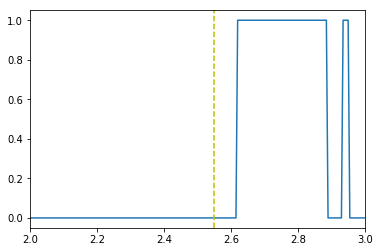

In [59]:
# '''
# Algorithm: Create Training Set
#   1. For every trial, get touch predictions and true label
#   2. Select window, and sweep window around true label. For simplicity, ignore cases when point outside window
# '''
# def time2frame(t, fps):
#     return int(t * FPS)-1

# iTrial = 0
# tStartSweep = 1.5 # Sec
# tStopSweep = 2.5 # Sec
# tWindow = 1.0 # Sec

# idxStartSweep = time2frame(tStartSweep, FPS)
# idxStopSweep  = time2frame(tStopSweep, FPS)
# nWindow     = time2frame(tWindow, FPS)

# dataLst = []
# labelLst = []
# for i in range(idxStartSweep, idxStopSweep):
#     data = HAVE_TOUCH[iTrial][i:i+nWindow]
#     label = touchTimesHuman[iTrial] - frame2time(i, FPS)
#     if (label > 0) and (label < tWindow):
#         dataLst += [data]
#         labelLst += [label]
    
# labelLstFr = [time2frame(t, FPS) for t in labelLst]
    
# # plt.figure()
# # plt.imshow(np.array(dataLst).T,extent=(0,200,0,200))
# # plt.plot(labelLstFr, color='r')
# # plt.show()
    

# plt.figure()
# plt.plot(np.arange(N_TIMES_MAX)/FPS, HAVE_TOUCH[iTrial])
# plt.axvline(x=touchTimesHuman[iTrial], color='y', linestyle='--')
# plt.xlim(1.5, )
# plt.show()

dict_keys(['channel_labels_all', 'data', 'lick_rate_all', 'lick_rate_distribution', 'lick_rate_go', 'lick_stat', 'mouse_IDs', 'paw_move', 'performance', 'reaction_time', 'reaction_time_distribution', 'sessions_IDs', 'touch_distribution', 'touch_stat', 'whisk_angle', 'whisk_envelope', 'whisk_stat', 'whisk_touch'])
